# XGBoost

## Prerequisites
- Regression trees
- Gradient boosting

## Intro - XGBoost summary
XGBoost is a shorthand for eXtreme Gradient Boost. It is much like gradient boosting with decision trees. Similarly, it starts by making a single constant estimate for all examples and then uses a decision tree which predicts not the label, but the size and magnitude of the update that needs to be made to the previous estimate. The difference lies in the type of tree that it uses to make predictions, how they are grown and cut down, and a bunch of optimisations that are made to allow it to work well for large datasets. Below, we firstly discuss the XGBoost trees, then making them into an ensemble, then the optimisations.

Here's a summary of the XGBoost algorithm
- make an initial prediction
- build an XGBoost tree the predicts the residual of the initial prediction
- prune the XGBoost tree
- build another tree that 
- stop when 


## XGBoost trees

Each XGBoost tree starts with a single leaf which contains all of the residuals between the final predictions and their labels. We then calculate a **similarity score** for this leaf. This similarity score is like the mean squared error except that the quantity is squared once the individual errors have been added rather than before.
This means that negative and positive errors can cancel out to reduce the overall similarity.
The prediction made by the leaf is always the mean of the examples; so there will be feature values above and below the prediction (if more than a single example).
The equation also includes a regularisation parameter $\lambda$ added to the denominator. 
You can see this from the equation used to compute it below.

## Similarity $= \frac{(\Sigma^k x - y)^2}{k+\lambda}$
Where k is the number of examples which this tree makes predictions for.

**Note: we do not square the residuals before adding them up.** This means that residuals that are on opposite sides of the prediction cancel each other out, reducing the similarity score. 

The question is: would splitting the data classified by this tree produce a total similarity that is less than the current similarity.
To do this, we consider every possible split of this subset of datapoints (every midpoint between successive datapoints ordered along each axis). So we test each of these points by splitting the data at that feature's value to produce two leaves, then we again evaluate the similarity score for each of those leaves and add them together. The difference between the original similarity score and the sum of similarity scores over each leaf of one of these XGBoost trees is called the **gain**.

$Gain \ = \ similarity_{left} + similarity_{right} - similarity_{root}$

This gain is a heuristic indicating the best way to extend the tree.
Unlike other trees, it is not weighted by the number of examples that end up in each region.
It is also dependent on the similarity score of the parent leaf. 
Relative rather than absolute?

We evaluate the gain resulting from each of the potential splits. 
Then we extend the tree by adding the best split to the 

## How is this type of tree different to regular boosting trees?
Instead of continuing to grow the tree by whichever split produces the least mean squared error (for regression), these XGBoost trees grow the tree by making branches (splits) that produce leaves with the greatest gain in similarity score.

## Why is it better?

## What is the meaning of the similarity score?

## Pruning trees
Once we have built a tree, we prune it based on it's similarity scores.
To do this, we choose a number $\gamma$. 
We then start at the branches closest to the leaves of the tree and evaluate whether the similarity score for each of them is greater than $\gamma$ by computing

$ similarity - \gamma$

If this quantity is less than zero, that is that the similarity is less than \gamma, then we remove that branch.

$\gamma$ is known as the tree complexity parameter.
This is because the larger it is, the greater the gain needed for a split to prevent it's fork being pruned, and more pruning reduces the capacity (complexity of representable functions) of the tree.

**Note that even if we set \gamma to zero, we do not turn off pruning because the gain may be negative, in which case the above equation will still be less than zero and cause the branch to be pruned.

When a leaf gets pruned, the predictions for examples that originally ended up at that leaf will now be made by the parent.
So the parent will become a predictor that makes predictions based on more examples.
The denominator in the similarity score computation then becomes less sensitive to lambda.

## The regularisation parameter $\lambda$
Recall that our equation for computing the similarity included a term in the denominator which was $+\lambda$.
$\lambda$'s effect on the similarity is to reduce the metrics' sensitivity to individual observations. 
It does this by increasing the susceptibility of branches to be pruned as it is increased.
When this happens, the examples that would have then been classified by each leaf stemming from that branch are now classified by a leaf which replaces it.
That is, a single prediction has to be made for a bunch of datapoints that were previously split into different leaves.
This prediction will have worse training error, but should help the model to generalise by reducing the sensitivity to more specific splits of data.
This is how $lambda$ regluarises the model and counteracts overfitting. 

## Making predictions with individual XGBoost trees
Once we've made these trees we need to make predictions for examples that end up on each leaf.
The predicted value for an example that arrives at a given leaf of an XGBoost regression tree is given by

## $output = \frac{sum\ of \ residuals}{number\ of\ residuals + \lambda}$

This is much like the calculation for the similarity score, except for the fact that we don't square the sum of the residuals. It is like taking the average of the labels of the examples from the training set that arrived at this leaf, except from the regularisation term which reduces the contribution that this tree has to the output as it increases. As the number of training examples at a leaf increases far beyond the value of lambda (or lambda = 0), the prediction tends to the average of the label.  

This prediction is added to the sequence of previous predictions when the trees are combined with the initial average prediction.
So increasing $\lambda$ reduces the influence of each tree on the output prediction.

## Let's implement an XGBoost regression tree from scratch.

In [104]:
from utils import get_regression_data, visualise_regression_predictions
X, Y = get_regression_data(m=30)


(30, 1) (30, 1)


4822690998982e-32
gain: -2.704005641919679e-31
similarity: 3.0814879110195774e-31
similarity: 0.22939975478120422
similarity: 0.22939975478120456
gain: 0.4587995095624088
similarity: 3.0814879110195774e-31
similarity: 0.28753480876806653
similarity: 0.28753480876806664
gain: 0.5750696175361332
similarity: 3.0814879110195774e-31
similarity: 1.8278644626605107
similarity: 1.8278644626605107
gain: 3.6557289253210214
best gain on this feature: 3.6557289253210214
split val: -0.5317495264712843, gain: 3.6557289253210214, split feature:0
similarity: 3.0814879110195774e-31
similarity: 0.45997583828075883
similarity: 0.4599758382807576
gain: 0.9199516765615164
similarity: 3.0814879110195774e-31
similarity: 1.372929307509451
similarity: 1.3729293075094495
gain: 2.745858615018901
similarity: 3.0814879110195774e-31
similarity: 0.45997583828075883
similarity: 0.4599758382807576
gain: 0.9199516765615164
similarity: 3.0814879110195774e-31
similarity: 7.804743615931096
similarity: 7.804743615931093
ga

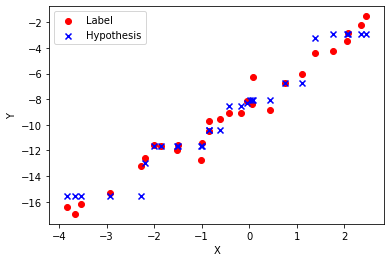

In [106]:
import sklearn.tree
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy
import numpy as np

# very similar to the regression tree that we implemented previously
class XGBoostTree:
    def __init__(self, max_depth=1):
        self.max_depth = max_depth

    def get_leaf_similarity_score(self, examples_in_region, prediction):
        """Return the similarity score for a leaf"""
        x, Y = examples_in_region
        # prediction = np.mean(Y)
        similarity = np.sum(Y - prediction)**2 # not mean squared error but squared mean error
        print('similarity:', similarity)
        return similarity

    def get_split_gain(self, x, Y, split_pos):
        """Get the gain for a given split"""
        parent_prediction = np.mean(Y)
        current_similarity = self.get_leaf_similarity_score((x, Y), parent_prediction)
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        first_region_similarity = self.get_leaf_similarity_score(in_first_region, parent_prediction)
        not_in_first_region_similarity = self.get_leaf_similarity_score(not_in_first_region, parent_prediction)
        gain = first_region_similarity + not_in_first_region_similarity - current_similarity
        print('gain:', gain)
        return gain

    def get_split_candidates(self, x):
        """Get the values of a given feature to be tested as a potential place to split"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Return the best feature and the best value to split the provided datapoints on"""
        best_feature_to_split_on = None
        best_gain = 0
        best_split_pos = None
        n_features = 1
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_gain = self.get_best_gain_on_this_feature(x, Y)
            print('best gain on this feature:', split_gain)
            if split_gain > best_gain:
                best_split_pos = split_pos
                best_gain = split_gain
                best_feature_to_split_on = feature_idx
        # print('best_split_gain:', best_gain)
        return best_split_pos, best_gain, best_feature_to_split_on

    def get_best_gain_on_this_feature(self, x, Y):
        """Get the best value to split the data on along this axis"""
        split_candidates = self.get_split_candidates(x)
        best_gain = 0
        best_split_pos = None
        for split_pos in split_candidates:
            gain = self.get_split_gain(x, Y, split_pos)
            if gain > best_gain:
                best_gain = gain
                best_split_pos = split_pos
        return best_split_pos, best_gain

    def extend_tree(self, X, Y, depth=0):
        """Recursively make branches of the tree"""
        split_val, split_gain, split_feature = self.get_best_split(X, Y)
        print(f'split val: {split_val}, gain: {split_gain}, split feature:{ split_feature}')
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_gain': 0, # so the split is pure
                'prediction': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_gain': split_gain,
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'prediction': np.mean(Y)})
        return new_branch

    def fit(self, X, Y):
        """Fit the tree to the data"""
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        """Return a prediction for a given input"""
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            tree = self.tree
            classified = False
            while classified == False:
                if 'prediction' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True
                    classifications[idx] = tree['prediction']
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example1 in the positive branch
                        tree = tree['positive_branch'] # 
                    else: 
                        tree = tree['negative_branch']
        return classifications

    def __repr__(self):
        """Return the pretty printed string"""
        return json.dumps(self.tree, indent=4)


## Ensembling XGBoost regression trees to build an XGBoost regression algorithm

Similarly to regular gradient boosting, XGBoost sequentially updates an initial prediction by adding predictions from a series of trees, weighted by a learning rate. 

The difference comes from
- the trees that are used are different
    - the best splits are evaluated using the gain in similarity score 
    - the predictions include a regularisation parameter lambda
- the pruning applied to trees after they are fit, determined by the tree complexity parameter

In XGBoost, the learning rate is known as $\eta$ (eta). The usual default is $0.3$.


In [ ]:
class XGBoost:
    def __init__(self, n_trees=10, learning_rate=0.1, tree_depth=1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.tree_depth = tree_depth

    def predict(self, X):
        # prediction = np.zeros(len(X))
        for tree_idx, tree in enumerate(self.trees):
            if tree_idx == 0:
                prediction = tree.predict(X)
            else:
                # print(tree.predict(X))
                # scd
                prediction += self.learning_rate * tree.predict(X)
            print(prediction)
        print()
        return prediction

    def fit(self, X, Y):
        self.trees = []
        target = Y
        for tree_idx in range(self.n_trees):
            print(f'tree {tree_idx}')
            tree = XGBoostTree(max_depth=self.tree_depth)
            # print('x:', X)
            # print(X.shape)
            tree.fit(X, target)
            # print('target:', target)
            # print(target.shape)
            self.trees.append(tree)
            prediction = tree.predict(X).reshape(-1, 1)
            # print('prediction:', prediction)
            # print(prediction.shape)
            target = target - prediction
            # print('residual:', target)
            print()

xgboost = XGBoost(n_trees=20, learning_rate=1, tree_depth=1)
xgboost.fit(X, Y)
predictions = xgboost.predict(X)
print(predictions)
visualise_regression_predictions(X, predictions, Y)


# XGBoost for classification

## Cover
The minimum number of residuals in each leaf of an XGBoost classification tree is determined by calculating the **cover** as such
 
$cover = \Sigma [previous\ probability_i \cdot (1 - previous\ probability_i)]$

The previous probability is the estimate that would be made if the parent node of this leaf were a leaf. 

This is the denominator of the similarity score minus $\lambda$.
It has a minimum of 1.
So if the computed value for cover is less than this minimum, XGBoost would not allow the leaf to be created.

## Pruning 
For classification we prune in the same way as for XGBoost regression.

## Prediction with XGBoost classification trees

The prediction for an XGBoost classification tree is given as the **log of the odds** of the example being a member of the positive class.

## $prediction = log(odds) = log(\frac{p}{1-p}) = \frac{\Sigma residual_i}{\Sigma (previous\ probability_i \cdot (1 - previous\ probability_i)  + \lambda}$

Other than lambda, this is the same formula used for regular gradient boosting.

**Note: $previous\ probability$ in the denominator is not the log odds predicted by any leaf of a tree, it is the actual probability. We would need to convert the log odds to a probability by applying the softmax function to it.

## Prediction with the whole XGBoost algorithm

We know that XGBoost is an ensemble method because it combines predictions made by multiple models.
For regression this is easy, because each model is just predicting the residual.
For classification it's a little different:

Firstly, the initial prediction was made by taking an average of the binary class labels, which means that it represents a probability. The predictions from each tree however represent something different, that is the $log(odds)$. Hence it doesn't make sense to add these different quantitites together. Before we do that we need to transform the initial prediction to represent a $log(odds)$. We do that by applying the following equation:

## $log(odds) = log(\frac{p}{1-p})$

**Note: This is the inverse of the logistic function.**

Secondly, the final output prediction does not represent the usual confidence that the example is a member of the positive class because it is a sum of the $log(odds)$ rather than that probability. So we need to transform it back from a $log(odds)$ to represent the probability which is what we care about.

This is because 1) they may sum up to more than 1 which doesn't make sense for a probability and 2) because the residual may be negative, and the equation for computing the output of a leaf is always positive.
So to sum them, we sequentially add the prediction from each tree, weighted by the learning rate $\eta$, to the initial prediction.

We can convert this final prediction back into a probability by applying the logistic function to it:

## $probability = \sigma(log(odds)) = \frac{1}{1 + e^{-log(odds)}}$

## What's extreme about XGBoost (eXtreme Gradient Boost)? 

The above is really only part of XGBoost

Several techniques are employed in the XGBoost algorithm to improve the time it takes to fit.
They are:
- the approximate greedy algorithm

We'll talk through each of these below.

### The approximate greedy algorithm
Because the tree splits are made based on the immediate gain, without considering how the examples that end up on that leaf might be separated by further splits, the algorithm is **greedy**.
If the algorithm did not choose to make splits greedily, it would have to consider all possible ways to grow the tree.
Exponentially many more trees become possible as the number of branches increase, so because it acts greedily, XGBoost does not waste time rolling out all possible future splits and evaluating them from a given new leaf.

As the number of examples increases, so does the number of possible splits (midpoints between any particular feature examples), and hence the compute time and memory.

The number of features of each example also linearly increases the number of splits that need to be considered, and hence the compute time and memory.

To counteract this, XGBoost does not consider every possible feature midpoint between sequential examples over all different feature dimensions. 
Instead it groups the examples into quantiles and considers splitting the data at only those positions.
The number of quantiles is a hyperparameter.
For example, if we chose to split a dataset of 30 examples into 3 quantiles, then for each feature, we would test splitting the data at the value of the 10th and 20th example's feature value.
This would reduce the number of splits to test from 29 down to 2.
This is called the *approximate* greedy algorithm.

# diagram of data split by quantile

### 

### Weighted quantile sketches

#### Quantile sketches
Firstly, what is a quantile sketch?

In practice, when we have LOTS of data, even sorting the examples to find quantiles of features becomes non-trivial and time consuming.

Instead, we 

#### Weighted quantile sketch

### Sparsity-aware split finding


### Cache-aware access
Put the data on the cache

### Blocks for out of core computation
Compress the data using the CPU so that more of it can fit there.